In [27]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import savetxt
import itertools, pickle
from itertools import product
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense,Flatten
from sklearn.metrics import classification_report, confusion_matrix
#loading the VGG16 model
vgg16_model=tf.keras.applications.vgg16.VGG16(input_shape= [224,224,3], weights='imagenet', include_top=False)

In [3]:
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

In [4]:
vgg16_model.layers.pop()

In [5]:
for layer in vgg16_model.layers:
        layer.trainable=False

In [6]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
x = Flatten()(vgg16_model.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=vgg16_model.input, outputs=prediction)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
model.compile(Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [30]:
tensorboard = callbacks.TensorBoard(log_dir='tb_logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("model_checkpoints/checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)

In [11]:
## [ToDo] Read from folders. Refer: /home/puneet/code/IER_TL

test_images=pd.read_csv("data_files/image_labels.csv") #Test CSV file containing label, image (and optionally, text)
test=[]
for i in test_images['image']:
    img=load_img(i,target_size=(224,224))
    img=img_to_array(img)
    img=img/255
    test.append(img)
test_new=np.array(test)
#y_new=model.predict(test_new)
#y_pred_class = np.argmax(y_new,axis=1)
#print(y_pred_class)
labels=[y for y in test_images['label']]
l=np.array(labels)

In [12]:
model.fit(
  test_new,l,
  validation_split=0.3,
  epochs=1,
  batch_size=20, 
  verbose=1,
  shuffle=True,
  callbacks=[tensorboard, model_checkpoints]
)

35/35 [==============================] - 89s 3s/step - loss: 1.2950 - accuracy: 0.5086 - val_loss: 1.0493 - val_accuracy: 0.6000


In [13]:
model.save('model_checkpoints/IER.h5')

In [14]:
model_img=load_model('model_checkpoints/IER.h5')

In [ ]:
test_images=pd.read_csv("data_files/image_labels.csv")
test_labels=[y for y in test_images['label']]
test=[]
for i in test_images['image']:
    img=load_img(i,target_size=(224,224))
    img=img_to_array(img)
    img=img/255
    test.append(img)
test_new=np.array(test)
y_new=model_img.predict(test_new)
y_pred_class = np.argmax(y_new,axis=1)

In [19]:
print(len(y_pred_class))
print(len(test_labels))

1000
1000


In [22]:
#Y_test = np.argmax(labels, axis=1)          # Convert one-hot to index
#y_pred = model.predict(data)
#y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(test_labels, y_pred_class)

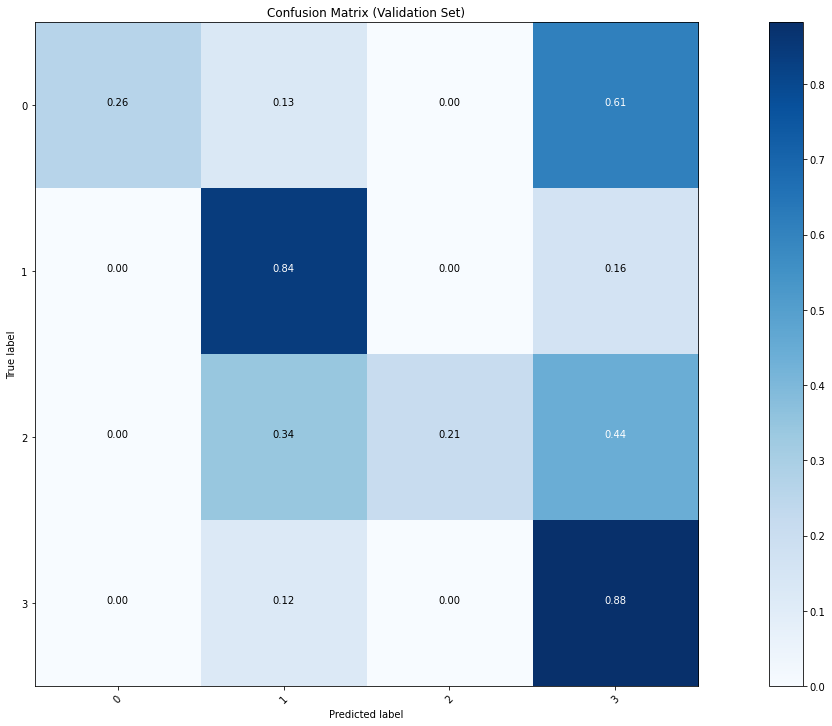

In [28]:
def plot_confusion_matrix(cm, labels, normalize=True, title='Confusion Matrix (Validation Set)', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(4)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=None)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [29]:
savetxt('data_files/img_prob.csv', y_new, delimiter=',')
savetxt('data_files/img_pred.csv', y_pred_class, delimiter=',')